In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, log_loss
from sklearn.calibration import calibration_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

pd.set_option('display.max_columns', None)

df = pd.read_csv('stay_reg_time_standardized_data.csv', sep=',')

In [2]:
# Convert 'admittime' to datetime
df['admittime'] = pd.to_datetime(df['admittime'], utc=True)

# Convert 'charttime' to datetime
df['charttime'] = pd.to_datetime(df['charttime'], utc=True)

# Calculate the difference in time
df['time_diff_admit_chart'] = df['charttime'] - df['admittime']

# Threshold for time difference (in hours)
threshold_hours = 2
threshold_timedelta = pd.Timedelta(hours=threshold_hours)

# Count rows with time difference < threshold and AMI (AMI_No_AMI = 1)
less_than_ami = df[(df['time_diff_admit_chart'] < threshold_timedelta) & (df['AMI_No_AMI'] == 1)].shape[0]

# Count rows with time difference >= threshold and AMI (AMI_No_AMI = 1)
greater_equal_ami = df[(df['time_diff_admit_chart'] >= threshold_timedelta) & (df['AMI_No_AMI'] == 1)].shape[0]

# print(df.head())

print(f"Number of patients with time difference < {threshold_hours} hours and AMI: {less_than_ami}")
print(f"Number of patients with time difference >= {threshold_hours} hours and AMI: {greater_equal_ami}")

# Drop admittime, charttime and storetime
df = df.drop(['admittime', 'charttime', 'storetime', 'time_diff_admit_chart'], axis=1)

# df_standardised = df.copy()

# # Transform time_diff_admit_chart to hours
# df_standardised['time_diff_admit_chart'] = df_standardised['time_diff_admit_chart'].dt.total_seconds() / 3600

# # Handle missing values with flag imputation
# df_standardised['time_diff_admit_chart'].fillna(-999, inplace=True)

# # Standardise time_diff_admit_chart
# df_standardised['time_diff_admit_chart'] = (df_standardised['time_diff_admit_chart'] - df_standardised['time_diff_admit_chart'].mean()) / df_standardised['time_diff_admit_chart'].std()

Number of patients with time difference < 2 hours and AMI: 3458
Number of patients with time difference >= 2 hours and AMI: 14270


In [3]:
# Number of patient with and without AMI
ami_count = df['AMI_No_AMI'].value_counts().get(1, 0)
no_ami_count = df['AMI_No_AMI'].value_counts().get(0, 0)

print(f'Total AMI: {ami_count}, Total No AMI: {no_ami_count}')

print(f'Total AMI_No_AMI: {len(df)}')

Total AMI: 17881, Total No AMI: 23489
Total AMI_No_AMI: 41370


In [4]:
# Summary statistics
summary = df.describe()

print(summary)

         subject_id       hadm_id     stay_time         Death      reg_time  \
count  4.137000e+04  4.137000e+04  4.137000e+04  41370.000000  4.137000e+04   
mean   1.498479e+07  2.500786e+07  8.179911e-18      0.075780  2.510038e-16   
std    2.886155e+06  2.876715e+06  1.000000e+00      0.264648  1.000000e+00   
min    1.000008e+07  2.000009e+07 -7.226749e-01      0.000000 -3.499042e+00   
25%    1.246344e+07  2.251127e+07 -5.174895e-01      0.000000 -8.966509e-01   
50%    1.497469e+07  2.501861e+07 -2.993146e-01      0.000000 -1.486396e-01   
75%    1.747799e+07  2.748452e+07  1.045722e-01      0.000000  3.036099e-01   
max    1.999999e+07  2.999967e+07  2.958036e+01      1.000000  2.387535e+01   

       hospital_expire_flag  average_troponin_level  average_cholesterol_HDL  \
count          41370.000000            4.137000e+04             4.137000e+04   
mean               0.075852           -1.862492e-15            -8.684429e-16   
std                0.264764            1.000000e

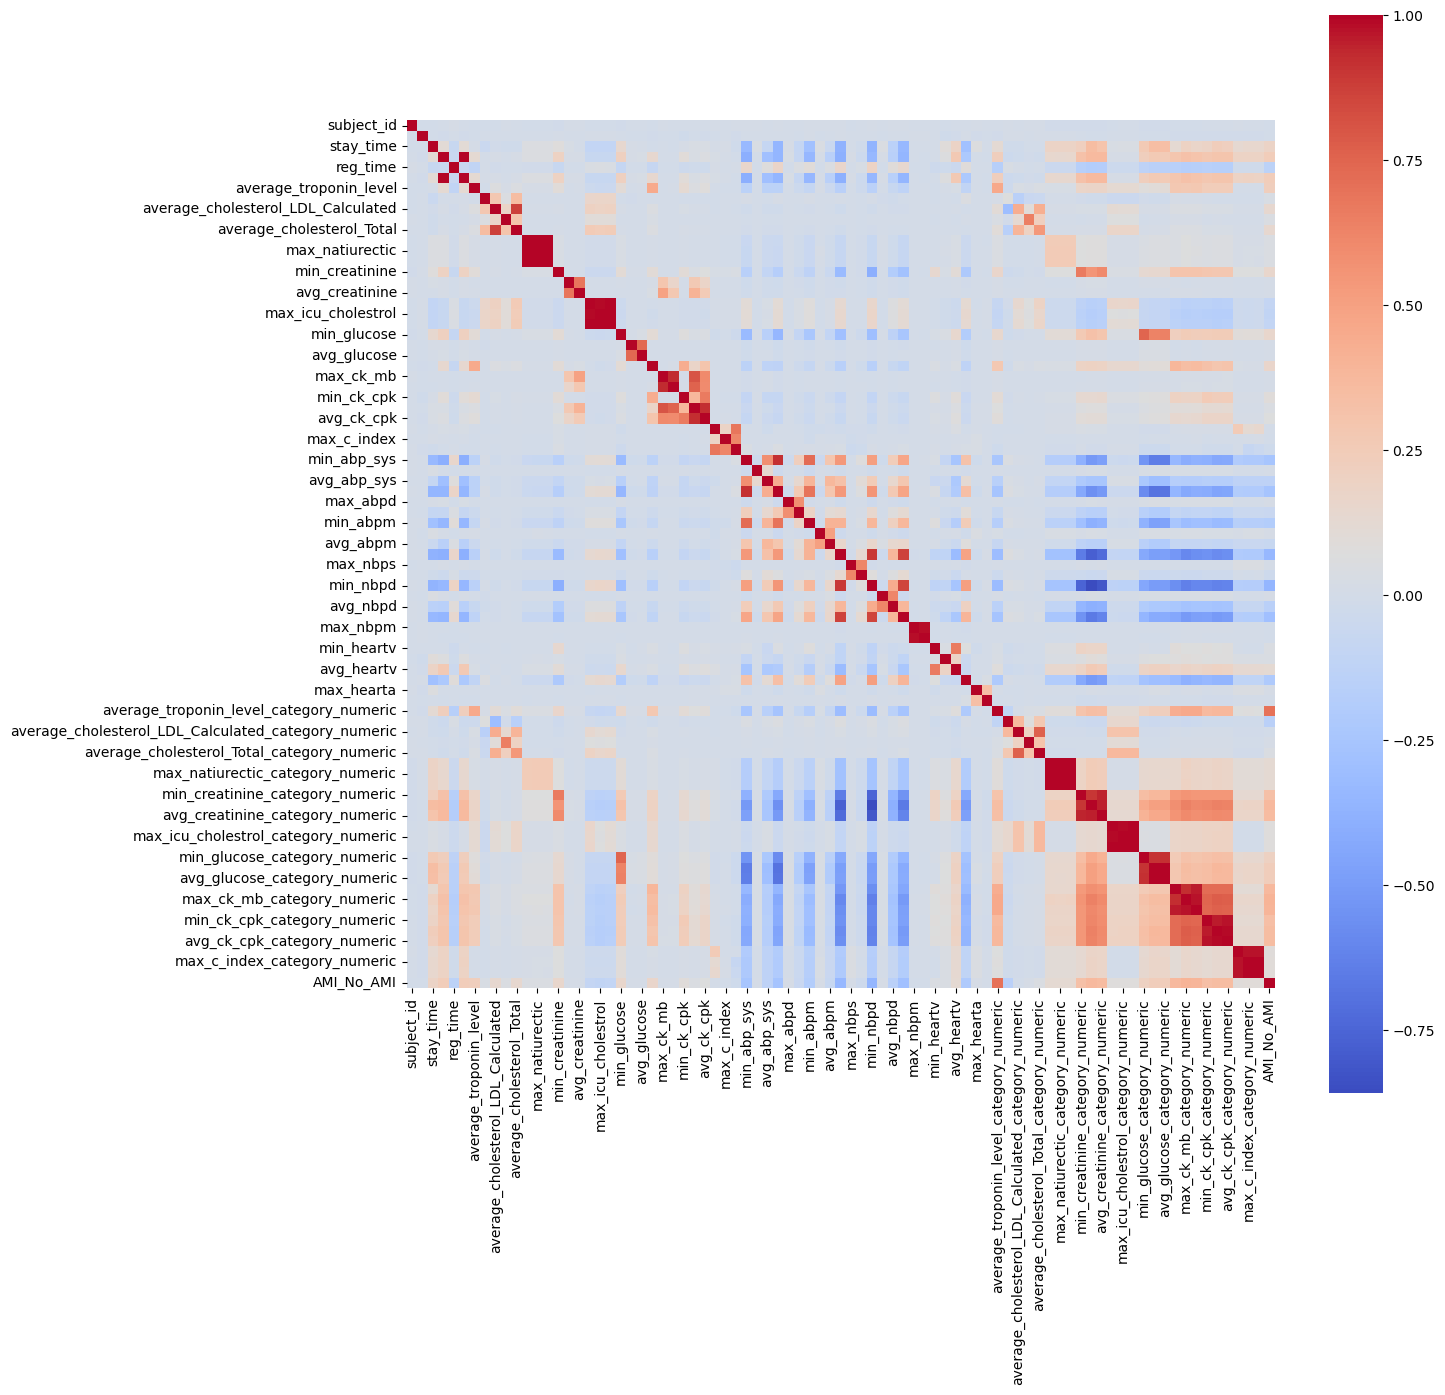

In [5]:
correlation_matrix = df.corr()

plt.figure(figsize=(14,14))
sns.heatmap(correlation_matrix, fmt='.2f', cmap='coolwarm', square=True)
# annot=True
plt.show()

In [6]:
label_correlation = correlation_matrix['AMI_No_AMI']
pd.set_option('display.max_rows', None)

print(label_correlation)

subject_id                                            -0.003038
hadm_id                                               -0.005444
stay_time                                              0.181798
Death                                                  0.244666
reg_time                                              -0.134600
hospital_expire_flag                                   0.244689
average_troponin_level                                 0.229089
average_cholesterol_HDL                                0.027134
average_cholesterol_LDL_Calculated                     0.140461
average_cholesterol_LDL_Measured                       0.045224
average_cholesterol_Total                              0.136601
min_natiurectic                                        0.041710
max_natiurectic                                        0.042625
avg_natiurectic                                        0.042175
min_creatinine                                         0.157514
max_creatinine                          

In [7]:
abs_correlations = label_correlation.abs()

rounded_correlations = abs_correlations.round(2)

# Select features with correlation >= 0.2
high_correlations = rounded_correlations[rounded_correlations >= 0.2]

print("Features with correlation >= 0.2 with AMI_No_AMI (rounded):")
features = list(high_correlations.keys())
features.remove("AMI_No_AMI")
print(features)

Features with correlation >= 0.2 with AMI_No_AMI (rounded):
['Death', 'hospital_expire_flag', 'average_troponin_level', 'min_abp_sys', 'min_abpd', 'min_nbps', 'min_nbpd', 'min_nbpm', 'min_hearta', 'average_troponin_level_category_numeric', 'min_creatinine_category_numeric', 'max_creatinine_category_numeric', 'avg_creatinine_category_numeric', 'min_glucose_category_numeric', 'max_glucose_category_numeric', 'avg_glucose_category_numeric', 'min_ck_mb_category_numeric', 'max_ck_mb_category_numeric', 'avg_ck_mb_category_numeric', 'min_ck_cpk_category_numeric', 'max_ck_cpk_category_numeric', 'avg_ck_cpk_category_numeric']


In [8]:
X = df[features]
y = df['AMI_No_AMI']
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, stratify=y)#80%train 20%rem
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, stratify=y_rem)#10%val 10%test

In [9]:
K = [3, 5, 7, 9, 11, 13, 15, 17, 19]
weight = ['uniform', 'distance']
p_value = [1, 2] # 1 for Manhattan, 2 for Euclidean distance
best_acc = 0
for i in weight:
    for p in p_value:
        for k in K:
            knn = KNeighborsClassifier(n_neighbors=k, 
                                       weights=i, 
                                       p=p)
            knn.fit(X_train, y_train)
            y_pred_knn = knn.predict(X_valid)
            print("weight: ", i)
            if (p==1):
                print("distance function: Manhattan")
            else:
                print("distance function: Euclidean")
            print("K: ", k)
            accuracy = accuracy_score(y_valid, y_pred_knn)
            print("accuracy: ", accuracy)
            if (accuracy >= best_acc):
                best_acc = accuracy
                best_weight = i
                best_p = p
                best_k = k
            
            print("\n")

C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  3
accuracy:  0.9006526468455403




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  5
accuracy:  0.8982354363065023




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  7
accuracy:  0.9013778100072516




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  9
accuracy:  0.9006526468455403




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  11
accuracy:  0.900894367899444




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  13
accuracy:  0.9006526468455403




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  15
accuracy:  0.8999274836838289




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  17
accuracy:  0.8999274836838289




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  19
accuracy:  0.9001692047377327




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  3
accuracy:  0.8994440415760213




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  5
accuracy:  0.8955765047135605




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  7
accuracy:  0.900894367899444




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  9
accuracy:  0.8989605994682137




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  11
accuracy:  0.9004109257916364




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  13
accuracy:  0.8970268310369833




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  15
accuracy:  0.8982354363065023




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  17
accuracy:  0.8965433889291757




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  19
accuracy:  0.8975102731447909


weight:  distance
distance function: Manhattan
K:  3
accuracy:  0.9025864152767706


weight:  distance
distance function: Manhattan
K:  5
accuracy:  0.903311578438482


weight:  distance
distance function: Manhattan
K:  7
accuracy:  0.9083877205704617


weight:  distance
distance function: Manhattan
K:  9
accuracy:  0.9103214890016921


weight:  distance
distance function: Manhattan
K:  11
accuracy:  0.9100797679477882


weight:  distance
distance function: Manhattan
K:  13
accuracy:  0.9108049311094997


weight:  distance
distance function: Manhattan
K:  15
accuracy:  0.9108049311094997


weight:  distance
distance function: Manhattan
K:  17
accuracy:  0.9110466521634034


weight:  distance
distance function: Manhattan
K:  19
accuracy:  0.9120135363790186


weight:  distance
distance function: Euclidean
K:  3
accuracy:  0.9013778100072516


weight:  distance
distance function: Euclidean
K:  5
accuracy

w:  distance p:  1 k:  19


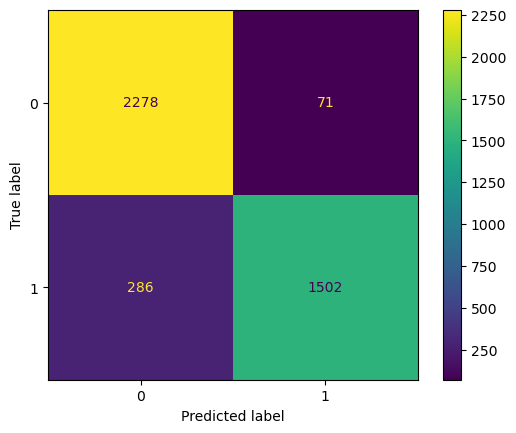

KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.97      0.93      2349
         1.0       0.95      0.84      0.89      1788

    accuracy                           0.91      4137
   macro avg       0.92      0.90      0.91      4137
weighted avg       0.92      0.91      0.91      4137

KNN ROC-AUC Score:  0.9420170704274179
KNN Log Loss: 1.4393163522495922


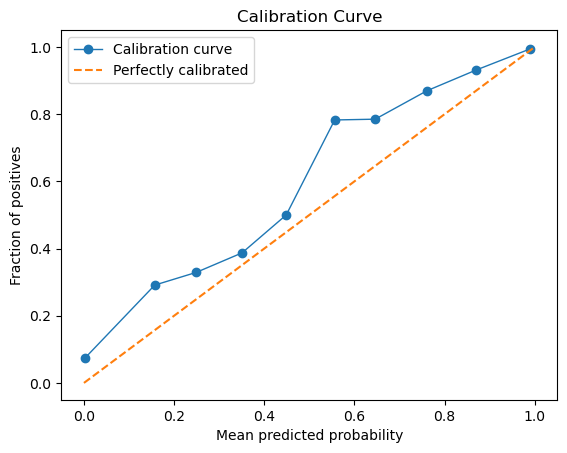

In [10]:
print("w: ", best_weight, "p: ", best_p, "k: ", best_k)
knn_best = KNeighborsClassifier(n_neighbors=best_k, 
                                weights=best_weight, 
                                p=best_p)
knn_best.fit(X_train, y_train)
y_pred_knn = knn_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("KNN ROC-AUC Score: ", roc_auc_score(y_test, knn_best.predict_proba(X_test)[:, 1]))
print("KNN Log Loss:", log_loss(y_test, knn_best.predict_proba(X_test)[:, 1]))

prob_true, prob_pred = calibration_curve(y_test, knn_best.predict_proba(X_test)[:, 1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [11]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
ratio = [0, 0.25, 0.5, 0.75, 1]
best_acc = 0

for p in penalty:
    for s in solver:
        if (p in ['l1', 'elasticnet'] and s in ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']) or \
           (p in ['none', 'elasticnet'] and s == 'liblinear'):
            continue
        if p == 'elasticnet' and s == 'saga':
            for r in ratio:
                lr = LogisticRegression(random_state=42, penalty=p, solver=s, l1_ratio=r)
                lr.fit(X_train, y_train)
                y_pred_lr = lr.predict(X_valid)
                print("penalty: ", p)
                print("solver: ",s)
                print("ratio: ",r)
                accuracy = accuracy_score(y_valid, y_pred_lr)
                print("accuracy: ", accuracy)
                if (accuracy >= best_acc):
                    best_acc = accuracy
                    best_penalty = p
                    best_solver = s
                    best_ratio = r
                print("\n")
            continue
        else:
            lr = LogisticRegression(random_state=42, penalty=p, solver=s)
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_valid)
        print("penalty: ", p)
        print("solver: ",s)
        accuracy = accuracy_score(y_valid, y_pred_lr)
        print("accuracy: ", accuracy)
        if (accuracy >= best_acc):
            best_acc = accuracy
            best_penalty = p
            best_solver = s
        print("\n")

penalty:  l1
solver:  liblinear
accuracy:  0.8774474256707759




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


penalty:  l1
solver:  saga
accuracy:  0.8784143098863911


penalty:  l2
solver:  lbfgs
accuracy:  0.8781725888324873


penalty:  l2
solver:  liblinear
accuracy:  0.8779308677785835


penalty:  l2
solver:  newton-cg
accuracy:  0.8781725888324873




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l2
solver:  sag
accuracy:  0.8779308677785835




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l2
solver:  saga
accuracy:  0.8781725888324873




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0
accuracy:  0.8781725888324873




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.25
accuracy:  0.8781725888324873




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.5
accuracy:  0.8781725888324873




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.75
accuracy:  0.8781725888324873




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


penalty:  elasticnet
solver:  saga
ratio:  1
accuracy:  0.8784143098863911


penalty:  none
solver:  lbfgs
accuracy:  0.8781725888324873


penalty:  none
solver:  newton-cg
accuracy:  0.8779308677785835




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  none
solver:  sag
accuracy:  0.8779308677785835


penalty:  none
solver:  saga
accuracy:  0.8774474256707759




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


p:  elasticnet s:  saga
r:  1


C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


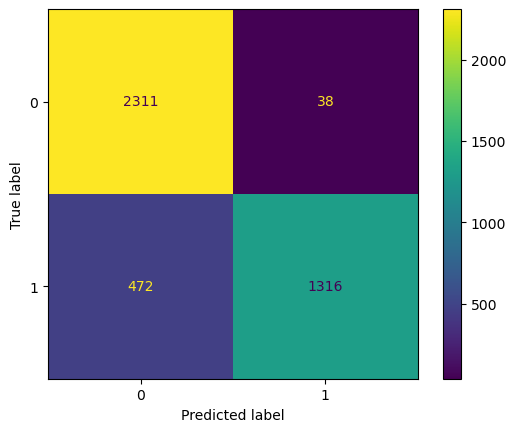

Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.98      0.90      2349
         1.0       0.97      0.74      0.84      1788

    accuracy                           0.88      4137
   macro avg       0.90      0.86      0.87      4137
weighted avg       0.89      0.88      0.87      4137

Logistic Regression ROC-AUC Score:  0.8648694337063798
Logistic Regression Log Loss: 0.3242357910532043


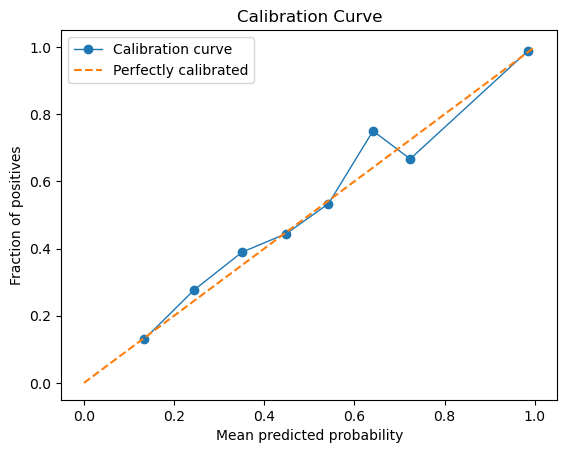

In [12]:
print("p: ", best_penalty, "s: ", best_solver)
if best_penalty == 'elasticnet' and best_solver == 'saga':
    print("r: ", best_ratio)
    lr_best = LogisticRegression(random_state=42, penalty=best_penalty, solver=best_solver, l1_ratio=best_ratio)
else:
    lr_best = LogisticRegression(random_state=42, penalty=best_penalty, solver=best_solver)

lr_best.fit(X_train, y_train)
y_pred_lr = lr_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Logistic Regression ROC-AUC Score: ", roc_auc_score(y_test, lr_best.predict_proba(X_test)[:, 1]))     
print("Logistic Regression Log Loss:", log_loss(y_test, lr_best.predict_proba(X_test)[:, 1]))

prob_true, prob_pred = calibration_curve(y_test, lr_best.predict_proba(X_test)[:, 1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [13]:
n_estimators = [25, 50, 75, 100]
max_features = ['sqrt', 'log2', None]
min_samples_split = [2, 5, 10] 
best_acc = 0
for i in n_estimators:
    for f in max_features:
        for ss in min_samples_split:
            rf = RandomForestClassifier(random_state=42, 
                                        n_estimators = i, 
                                        max_features = f,
                                        min_samples_split = ss)
            rf.fit(X_train, y_train)
            y_pred_rf = rf.predict(X_valid)
            print("n_estimators: ", i)
            print("max_features: ",f)
            print("min_samples_split: ", ss)
            accuracy = accuracy_score(y_valid, y_pred_rf)
            print("accuracy: ", accuracy)
            if (accuracy >= best_acc):
                best_acc = accuracy
                best_n_estimators = i
                best_max_features = f
                best_min_samples_split = ss
            print("\n")

n_estimators:  25
max_features:  sqrt
min_samples_split:  2
accuracy:  0.9320763838530336


n_estimators:  25
max_features:  sqrt
min_samples_split:  5
accuracy:  0.9328015470147449


n_estimators:  25
max_features:  sqrt
min_samples_split:  10
accuracy:  0.9323181049069373


n_estimators:  25
max_features:  log2
min_samples_split:  2
accuracy:  0.9320763838530336


n_estimators:  25
max_features:  log2
min_samples_split:  5
accuracy:  0.9328015470147449


n_estimators:  25
max_features:  log2
min_samples_split:  10
accuracy:  0.9323181049069373


n_estimators:  25
max_features:  None
min_samples_split:  2
accuracy:  0.9313512206913223


n_estimators:  25
max_features:  None
min_samples_split:  5
accuracy:  0.931592941745226


n_estimators:  25
max_features:  None
min_samples_split:  10
accuracy:  0.9323181049069373


n_estimators:  50
max_features:  sqrt
min_samples_split:  2
accuracy:  0.9325598259608412


n_estimators:  50
max_features:  sqrt
min_samples_split:  5
accuracy:  0.93207

n:  50 mf:  log2 mss:  10


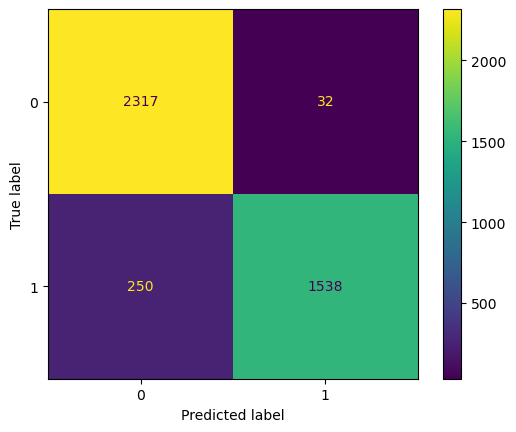

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      2349
         1.0       0.98      0.86      0.92      1788

    accuracy                           0.93      4137
   macro avg       0.94      0.92      0.93      4137
weighted avg       0.94      0.93      0.93      4137

Random Forest ROC-AUC Score:  0.9470307465788194
Random Forest Log Loss: 0.20649054963453117


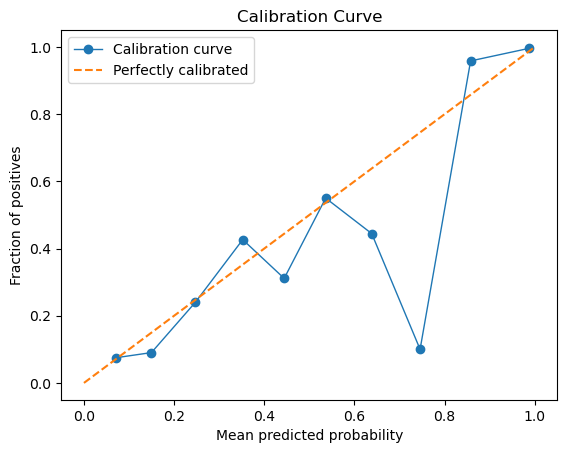

In [14]:
print("n: ", best_n_estimators, "mf: ", best_max_features, "mss: ", best_min_samples_split)
rf_best = RandomForestClassifier(random_state=42, 
                                 n_estimators = best_n_estimators, 
                                 max_features = best_max_features, 
                                 min_samples_split = best_min_samples_split )
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest ROC-AUC Score: ", roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1]))
print("Random Forest Log Loss:", log_loss(y_test, rf_best.predict_proba(X_test)[:, 1]))

prob_true, prob_pred = calibration_curve(y_test, rf_best.predict_proba(X_test)[:, 1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# troponin

In [15]:
label_correlation = correlation_matrix['average_troponin_level_category_numeric']
pd.set_option('display.max_rows', None)

print(label_correlation)

subject_id                                            -0.000517
hadm_id                                               -0.012123
stay_time                                              0.115066
Death                                                  0.228174
reg_time                                              -0.164411
hospital_expire_flag                                   0.228318
average_troponin_level                                 0.462648
average_cholesterol_HDL                                0.013962
average_cholesterol_LDL_Calculated                     0.102674
average_cholesterol_LDL_Measured                       0.038097
average_cholesterol_Total                              0.095240
min_natiurectic                                        0.042847
max_natiurectic                                        0.044083
avg_natiurectic                                        0.043459
min_creatinine                                         0.164234
max_creatinine                          

In [16]:
abs_correlations = label_correlation.abs()

rounded_correlations = abs_correlations.round(2)

# Select features with correlation >= 0.2
high_correlations = rounded_correlations[rounded_correlations >= 0.2]

print("Features with correlation >= 0.2 with average_troponin_level_category_numeric (rounded):")
features = list(high_correlations.keys())
features.remove("AMI_No_AMI")
features.remove("average_troponin_level")
features.remove("average_troponin_level_category_numeric")
print(features)

Features with correlation >= 0.2 with average_troponin_level_category_numeric (rounded):
['Death', 'hospital_expire_flag', 'min_ck_mb', 'min_abp_sys', 'min_abpd', 'min_nbps', 'min_nbpd', 'min_nbpm', 'min_hearta', 'min_creatinine_category_numeric', 'max_creatinine_category_numeric', 'avg_creatinine_category_numeric', 'min_glucose_category_numeric', 'max_glucose_category_numeric', 'avg_glucose_category_numeric', 'min_ck_mb_category_numeric', 'max_ck_mb_category_numeric', 'avg_ck_mb_category_numeric', 'min_ck_cpk_category_numeric', 'max_ck_cpk_category_numeric', 'avg_ck_cpk_category_numeric']


In [17]:
X = df[features]
y = df['average_troponin_level_category_numeric']
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, stratify=y)#80%train 20%rem
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, stratify=y_rem)#10%val 10%test

In [18]:
K = [3, 5, 7, 9, 11, 13, 15, 17, 19]
weight = ['uniform', 'distance']
p_value = [1, 2] # 1 for Manhattan, 2 for Euclidean distance
best_acc = 0
for i in weight:
    for p in p_value:
        for k in K:
            knn = KNeighborsClassifier(n_neighbors=k, 
                                       weights=i, 
                                       p=p)
            knn.fit(X_train, y_train)
            y_pred_knn = knn.predict(X_valid)
            print("weight: ", i)
            if (p==1):
                print("distance function: Manhattan")
            else:
                print("distance function: Euclidean")
            print("K: ", k)
            accuracy = accuracy_score(y_valid, y_pred_knn)
            print("accuracy: ", accuracy)
            if (accuracy >= best_acc):
                best_acc = accuracy
                best_weight = i
                best_p = p
                best_k = k
            
            print("\n")

C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  3
accuracy:  0.7196035774715978




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  5
accuracy:  0.7251631617113851




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  7
accuracy:  0.7258883248730964




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  9
accuracy:  0.7256466038191927




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  11
accuracy:  0.7270969301426154




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  13
accuracy:  0.7268552090887116




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  15
accuracy:  0.7270969301426154




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  17
accuracy:  0.7256466038191927




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Manhattan
K:  19
accuracy:  0.7239545564418661




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  3
accuracy:  0.7210539037950205




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  5
accuracy:  0.726371766980904




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  7
accuracy:  0.7241962774957699




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  9
accuracy:  0.7258883248730964




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  11
accuracy:  0.7241962774957699




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  13
accuracy:  0.7239545564418661




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  15
accuracy:  0.7225042301184433




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  17
accuracy:  0.7237128353879623




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


weight:  uniform
distance function: Euclidean
K:  19
accuracy:  0.7227459511723471


weight:  distance
distance function: Manhattan
K:  3
accuracy:  0.7241962774957699


weight:  distance
distance function: Manhattan
K:  5
accuracy:  0.7328982354363065


weight:  distance
distance function: Manhattan
K:  7
accuracy:  0.7326565143824028


weight:  distance
distance function: Manhattan
K:  9
accuracy:  0.7355571670292482


weight:  distance
distance function: Manhattan
K:  11
accuracy:  0.7362823301909597


weight:  distance
distance function: Manhattan
K:  13
accuracy:  0.7353154459753445


weight:  distance
distance function: Manhattan
K:  15
accuracy:  0.7348320038675369


weight:  distance
distance function: Manhattan
K:  17
accuracy:  0.7367657722987673


weight:  distance
distance function: Manhattan
K:  19
accuracy:  0.7355571670292482


weight:  distance
distance function: Euclidean
K:  3
accuracy:  0.7239545564418661


weight:  distance
distance function: Euclidean
K:  5
accurac

w:  distance p:  1 k:  17


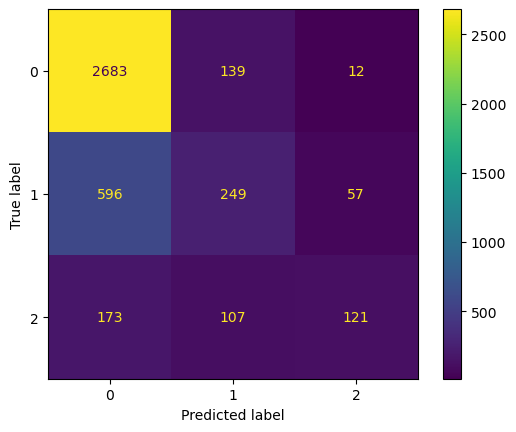

KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.95      0.85      2834
         1.0       0.50      0.28      0.36       902
         2.0       0.64      0.30      0.41       401

    accuracy                           0.74      4137
   macro avg       0.64      0.51      0.54      4137
weighted avg       0.70      0.74      0.70      4137

KNN ROC-AUC Score:  0.698725903835124
KNN Log Loss: 3.893522978578928


In [19]:
print("w: ", best_weight, "p: ", best_p, "k: ", best_k)
knn_best = KNeighborsClassifier(n_neighbors=best_k, 
                                weights=best_weight, 
                                p=best_p)
knn_best.fit(X_train, y_train)
y_pred_knn = knn_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2])
cm_display.plot()
plt.show()

print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("KNN ROC-AUC Score: ", roc_auc_score(y_test, knn_best.predict_proba(X_test), multi_class = 'ovo'))
print("KNN Log Loss:", log_loss(y_test, knn_best.predict_proba(X_test)))

In [20]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
ratio = [0, 0.25, 0.5, 0.75, 1]
best_acc = 0

for p in penalty:
    for s in solver:
        if (p in ['l1', 'elasticnet'] and s in ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']) or \
           (p in ['none', 'elasticnet'] and s == 'liblinear'):
            continue
        if p == 'elasticnet' and s == 'saga':
            for r in ratio:
                lr = LogisticRegression(random_state=42, penalty=p, solver=s, l1_ratio=r, multi_class='auto')
                lr.fit(X_train, y_train)
                y_pred_lr = lr.predict(X_valid)
                print("penalty: ", p)
                print("solver: ",s)
                print("ratio: ",r)
                accuracy = accuracy_score(y_valid, y_pred_lr)
                print("accuracy: ", accuracy)
                if (accuracy >= best_acc):
                    best_acc = accuracy
                    best_penalty = p
                    best_solver = s
                    best_ratio = r
                print("\n")
            continue
        else:
            lr = LogisticRegression(random_state=42, penalty=p, solver=s)
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_valid)
        print("penalty: ", p)
        print("solver: ",s)
        accuracy = accuracy_score(y_valid, y_pred_lr)
        print("accuracy: ", accuracy)
        if (accuracy >= best_acc):
            best_acc = accuracy
            best_penalty = p
            best_solver = s
        print("\n")

penalty:  l1
solver:  liblinear
accuracy:  0.7297558617355572




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l1
solver:  saga
accuracy:  0.7307227459511724




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


penalty:  l2
solver:  lbfgs
accuracy:  0.7299975827894609


penalty:  l2
solver:  liblinear
accuracy:  0.7302393038433648


penalty:  l2
solver:  newton-cg
accuracy:  0.7292724196277496




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l2
solver:  sag
accuracy:  0.7299975827894609




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l2
solver:  saga
accuracy:  0.7299975827894609




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0
accuracy:  0.7299975827894609




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.25
accuracy:  0.7299975827894609




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.5
accuracy:  0.7297558617355572




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.75
accuracy:  0.7304810248972685




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  1
accuracy:  0.7307227459511724




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


penalty:  none
solver:  lbfgs
accuracy:  0.7295141406816533


penalty:  none
solver:  newton-cg
accuracy:  0.7295141406816533




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  none
solver:  sag
accuracy:  0.7299975827894609


penalty:  none
solver:  saga
accuracy:  0.7304810248972685




C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


p:  elasticnet s:  saga
r:  1


C:\Users\Eric20021020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


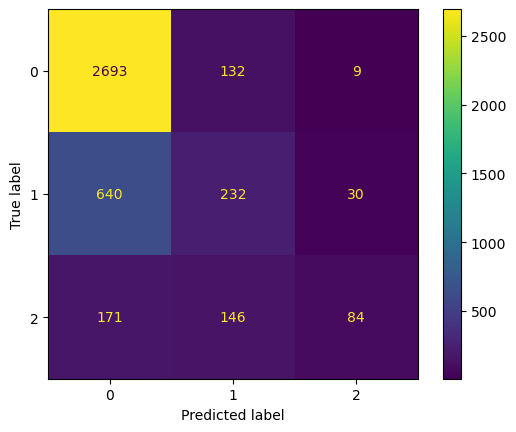

Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.95      0.85      2834
         1.0       0.45      0.26      0.33       902
         2.0       0.68      0.21      0.32       401

    accuracy                           0.73      4137
   macro avg       0.64      0.47      0.50      4137
weighted avg       0.69      0.73      0.68      4137

Logistic Regression ROC-AUC Score:  0.6849790300009014
Logistic Regression Log Loss: 0.6964283862143151


In [21]:
print("p: ", best_penalty, "s: ", best_solver)
if best_penalty == 'elasticnet' and best_solver == 'saga':
    print("r: ", best_ratio)
    lr_best = LogisticRegression(random_state=42, penalty=best_penalty, solver=best_solver, l1_ratio=best_ratio, 
                                 multi_class='auto')
else:
    lr_best = LogisticRegression(random_state=42, penalty=best_penalty, solver=best_solver, multi_class='auto')

lr_best.fit(X_train, y_train)
y_pred_lr = lr_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2])
cm_display.plot()
plt.show()

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Logistic Regression ROC-AUC Score: ", roc_auc_score(y_test, lr_best.predict_proba(X_test), multi_class = 'ovo'))     
print("Logistic Regression Log Loss:", log_loss(y_test, lr_best.predict_proba(X_test)))

In [22]:
n_estimators = [25, 50, 75, 100]
max_features = ['sqrt', 'log2', None]
min_samples_split = [2, 5, 10] 
best_acc = 0
for i in n_estimators:
    for f in max_features:
        for ss in min_samples_split:
            rf = RandomForestClassifier(random_state=42, 
                                        n_estimators = i, 
                                        max_features = f,
                                        min_samples_split = ss)
            rf.fit(X_train, y_train)
            y_pred_rf = rf.predict(X_valid)
            print("n_estimators: ", i)
            print("max_features: ",f)
            print("min_samples_split: ", ss)
            accuracy = accuracy_score(y_valid, y_pred_rf)
            print("accuracy: ", accuracy)
            if (accuracy >= best_acc):
                best_acc = accuracy
                best_n_estimators = i
                best_max_features = f
                best_min_samples_split = ss
            print("\n")

n_estimators:  25
max_features:  sqrt
min_samples_split:  2
accuracy:  0.7403915881073242


n_estimators:  25
max_features:  sqrt
min_samples_split:  5
accuracy:  0.7399081459995166


n_estimators:  25
max_features:  sqrt
min_samples_split:  10
accuracy:  0.7420836354846507


n_estimators:  25
max_features:  log2
min_samples_split:  2
accuracy:  0.7403915881073242


n_estimators:  25
max_features:  log2
min_samples_split:  5
accuracy:  0.7399081459995166


n_estimators:  25
max_features:  log2
min_samples_split:  10
accuracy:  0.7420836354846507


n_estimators:  25
max_features:  None
min_samples_split:  2
accuracy:  0.7365240512448634


n_estimators:  25
max_features:  None
min_samples_split:  5
accuracy:  0.7350737249214406


n_estimators:  25
max_features:  None
min_samples_split:  10
accuracy:  0.7401498670534203


n_estimators:  50
max_features:  sqrt
min_samples_split:  2
accuracy:  0.7391829828378051


n_estimators:  50
max_features:  sqrt
min_samples_split:  5
accuracy:  0.7406

n:  100 mf:  log2 mss:  10


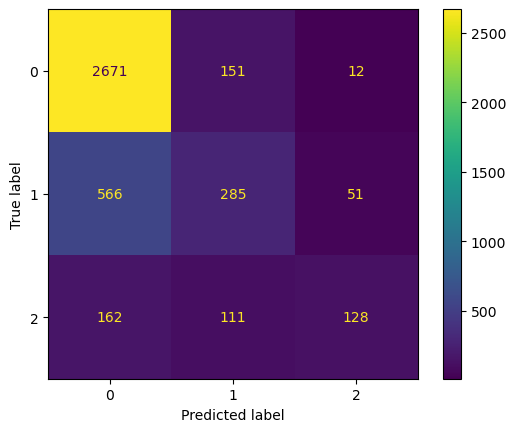

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.94      0.86      2834
         1.0       0.52      0.32      0.39       902
         2.0       0.67      0.32      0.43       401

    accuracy                           0.75      4137
   macro avg       0.66      0.53      0.56      4137
weighted avg       0.72      0.75      0.71      4137

Random Forest ROC-AUC Score:  0.715014874734241
Random Forest Log Loss: 0.663576898937316


In [23]:
print("n: ", best_n_estimators, "mf: ", best_max_features, "mss: ", best_min_samples_split)
rf_best = RandomForestClassifier(random_state=42, 
                                 n_estimators = best_n_estimators, 
                                 max_features = best_max_features, 
                                 min_samples_split = best_min_samples_split )
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2])
cm_display.plot()
plt.show()

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest ROC-AUC Score: ", roc_auc_score(y_test, rf_best.predict_proba(X_test), multi_class = 'ovo'))
print("Random Forest Log Loss:", log_loss(y_test, rf_best.predict_proba(X_test)))